# Import

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import seaborn as sns
import missingno as msno
import plotly.express as px

from tqdm import tqdm

from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import root_mean_squared_error, make_scorer

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score
import optuna

from tqdm import tqdm

import random
random.seed(42)
np.random.seed(42)

from features_eng import create_lag, full_df, correct_values


# Data loading 

In [2]:
# Data Loading
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

# Feature Engineering (Features creation + cleaning)

In [3]:
train = correct_values(train)
train = create_lag(train, 365)
train = full_df(train) 

c:\Users\leeno\Desktop\Ground level NO2\geoai-ground-level-no2-estimation-challenge20240612-4943-16iro0r\features_eng.py:11: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df['Date'] = pd.to_datetime(df['Date'], dayfirst=True, infer_datetime_format=True)  # Infer date format and use dayfirst if needed
c:\Users\leeno\Desktop\Ground level NO2\geoai-ground-level-no2-estimation-challenge20240612-4943-16iro0r\features_eng.py:11: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Date'] = pd.to_datetime(df['Date'], dayfirst=True, infer_datetime_format=True)  # Infer date format and use dayfirst if needed


In [4]:
train.shape

(86584, 384)

# Cross validation

In [5]:
# Adjust max_train_size or n_splits as needed
tscv = TimeSeriesSplit(n_splits=5, max_train_size=20000, test_size=5000, gap=100)

for train_index, test_index in tscv.split(train):
    print("TRAIN:", len(train_index), "TEST:", len(test_index))
    print("TRAIN:", train_index, "TEST:", test_index)
    print('***********')
    

TRAIN: 20000 TEST: 5000
TRAIN: [41484 41485 41486 ... 61481 61482 61483] TEST: [61584 61585 61586 ... 66581 66582 66583]
***********
TRAIN: 20000 TEST: 5000
TRAIN: [46484 46485 46486 ... 66481 66482 66483] TEST: [66584 66585 66586 ... 71581 71582 71583]
***********
TRAIN: 20000 TEST: 5000
TRAIN: [51484 51485 51486 ... 71481 71482 71483] TEST: [71584 71585 71586 ... 76581 76582 76583]
***********
TRAIN: 20000 TEST: 5000
TRAIN: [56484 56485 56486 ... 76481 76482 76483] TEST: [76584 76585 76586 ... 81581 81582 81583]
***********
TRAIN: 20000 TEST: 5000
TRAIN: [61484 61485 61486 ... 81481 81482 81483] TEST: [81584 81585 81586 ... 86581 86582 86583]
***********


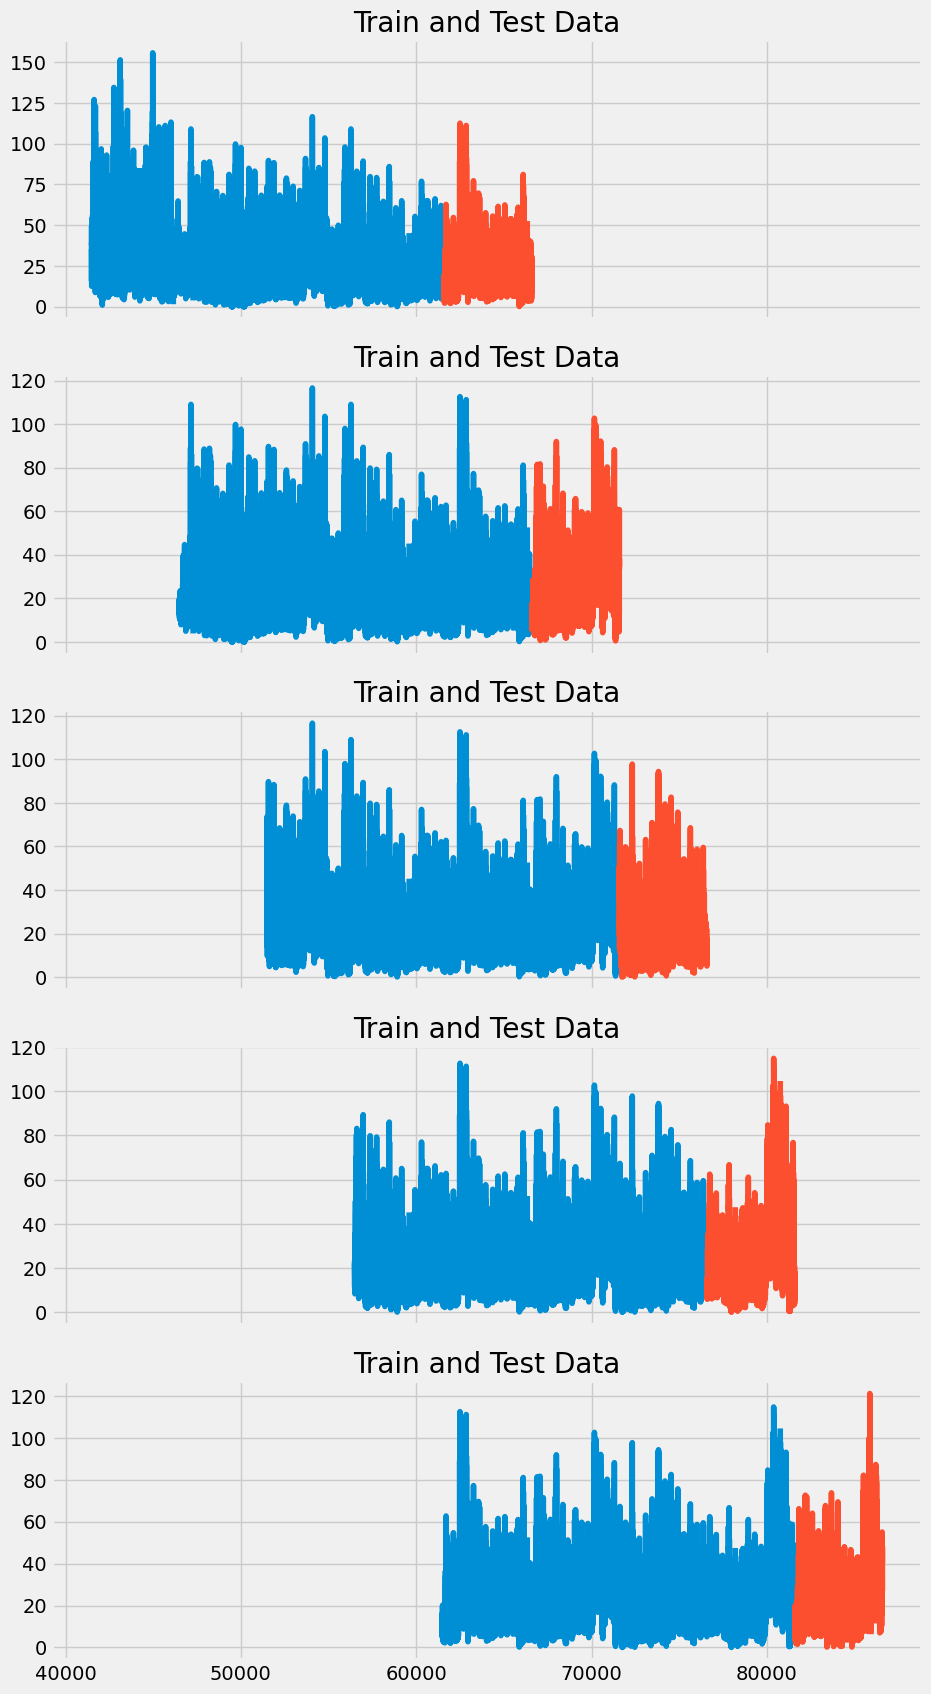

In [6]:
fig, axs = plt.subplots(5, 1, figsize = (10, 20), sharex = True)

fold = 0
for train_index, test_index in tscv.split(train):
    train_data = train.iloc[train_index]
    test_data = train.iloc[test_index]
    train_data['GT_NO2'].plot(ax = axs[fold],
                               label = 'Train',
                               title = 'Train and Test Data')
    test_data['GT_NO2'].plot(ax = axs[fold],
                               label = 'Test',
                               title = 'Train and Test Data')
    fold += 1
plt.show()

# Data preparation

In [7]:
train = train.dropna(subset=['GT_NO2'])
X = train.drop(columns=['GT_NO2'])
y = train['GT_NO2']

# Metric

In [11]:
rmse_scorer = make_scorer(root_mean_squared_error)

# XG Boost

In [12]:
xgb = XGBRegressor(base_score=0.5, booster='gbtree',
                    n_estimators=1000,
                    #early_stopping_rounds=50,
                    objective='reg:linear',
                    max_depth=3,
                    learning_rate=0.01)

In [13]:
%%time
cv_scores = cross_val_score(xgb, X, y, cv=tscv, scoring=rmse_scorer)

# Print the RMSE scores for each fold
print("Cross-validated RMSE scores:", cv_scores)
print("Mean RMSE:", np.mean(cv_scores))
print("Standard Deviation of RMSE:", np.std(cv_scores))

c:\Users\leeno\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [21:49:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)
c:\Users\leeno\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [21:49:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)
c:\Users\leeno\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [21:50:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warn

Cross-validated RMSE scores: [6.88856582 7.56699418 8.0724938  6.35077468 7.09595756]
Mean RMSE: 7.194957206687559
Standard Deviation of RMSE: 0.5873334178272321
CPU times: total: 15min 3s
Wall time: 56.8 s


## Hyper-parameter tunning (Too expensive)

def objective(trial):
    params = {
    'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
    'max_depth': trial.suggest_int('max_depth', 3, 50),
    'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
    'subsample': trial.suggest_float('subsample', 0.5, 1.0),
    'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
    'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 1.0),
    'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 1.0)
    }

    xgb = XGBRegressor(**params)
    score = cross_val_score(xgb, X, y, cv=tscv, scoring=rmse_scorer, n_jobs=-1).mean()
    return score

study = optuna.create_study(direction='minimize',
                            sampler = optuna.samplers.RandomSampler(seed=42))
study.optimize(objective, n_trials=500)

print("Best trial:")
trial = study.best_trial
print("  Value: ", trial.value)
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

# LightGBM

In [14]:
lgbm = LGBMRegressor(boosting_type='gbdt',
                     objective='regression',
                     num_leaves=30,
                     learning_rate=0.05,
                     n_estimators=100)

rmse_scorer = make_scorer(root_mean_squared_error)

In [16]:
%%time
cv_scores = cross_val_score(lgbm, X, y, cv=tscv, scoring=rmse_scorer, n_jobs=-1)

# Print the RMSE scores for each fold
print("Cross-validated RMSE scores:", cv_scores)
print("Mean RMSE:", np.mean(cv_scores))
print("Standard Deviation of RMSE:", np.std(cv_scores))

Cross-validated RMSE scores: [6.69870836 7.3365938  7.52270118 6.27561207 6.88758939]
Mean RMSE: 6.944240958177062
Standard Deviation of RMSE: 0.44701615620095403
CPU times: total: 547 ms
Wall time: 9.12 s


## Hyper-parameter tunning

In [19]:
# 1. Define an objective function to be maximized.
def objective(trial):
    ...

    # 2. Suggest values of the hyperparameters using a trial object.
    param = {
        'objective': 'regression',
        'metric': 'rmse',
        'verbosity': -1,
        'boosting_type': 'gbdt',
        'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 10.0, log=True),
        'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 10.0, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 2, 256),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.4, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.4, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
    }

    lgbm = LGBMRegressor(**param)
    score = cross_val_score(lgbm, X, y, cv=tscv, scoring=rmse_scorer, n_jobs=-1).mean()
    return score

In [20]:
%%time

study = optuna.create_study(direction='minimize',
                            sampler = optuna.samplers.RandomSampler(seed=42))
study.optimize(objective, n_trials=20)

print("Best trial:")
trial = study.best_trial
print("  Value: ", trial.value)
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2024-09-05 21:56:13,933] A new study created in memory with name: no-name-78bfa80a-5258-41ad-858b-aaaf75beb81a
[I 2024-09-05 21:56:40,417] Trial 0 finished with value: 6.856459548330122 and parameters: {'lambda_l1': 2.348881295853308e-05, 'lambda_l2': 3.6010467344475403, 'num_leaves': 188, 'feature_fraction': 0.759195090518222, 'bagging_fraction': 0.4936111842654619, 'bagging_freq': 2, 'min_child_samples': 10}. Best is trial 0 with value: 6.856459548330122.
[I 2024-09-05 21:57:02,916] Trial 1 finished with value: 6.776022876566737 and parameters: {'lambda_l1': 0.6245760287469893, 'lambda_l2': 0.002570603566117598, 'num_leaves': 182, 'feature_fraction': 0.41235069657748147, 'bagging_fraction': 0.9819459112971965, 'bagging_freq': 6, 'min_child_samples': 25}. Best is trial 1 with value: 6.776022876566737.
[I 2024-09-05 21:57:15,345] Trial 2 finished with value: 6.801104749267746 and parameters: {'lambda_l1': 4.329370014459266e-07, 'lambda_l2': 4.4734294104626844e-07, 'num_leaves': 79, 

Best trial:
  Value:  6.756784912922076
  Params: 
    lambda_l1: 1.8007140198129195e-07
    lambda_l2: 4.258943089524393e-06
    num_leaves: 95
    feature_fraction: 0.6736419905302216
    bagging_fraction: 0.8711055768358081
    bagging_freq: 2
    min_child_samples: 54
CPU times: total: 3.62 s
Wall time: 4min 37s


## Visualization

In [21]:
study.best_params

{'lambda_l1': 1.8007140198129195e-07,
 'lambda_l2': 4.258943089524393e-06,
 'num_leaves': 95,
 'feature_fraction': 0.6736419905302216,
 'bagging_fraction': 0.8711055768358081,
 'bagging_freq': 2,
 'min_child_samples': 54}

In [22]:
optuna.visualization.plot_optimization_history(study)

In [23]:
optuna.visualization.plot_parallel_coordinate(study)

In [25]:
optuna.visualization.plot_slice(study, params=['lambda_l1', 'lambda_l2', 'num_leaves', 'feature_fraction', 'bagging_fraction', 'bagging_freq', 'min_child_samples' ])

In [26]:
optuna.visualization.plot_param_importances(study)

# Cat Boost